<a href="https://colab.research.google.com/github/nrvanwyck/DS-Unit-1-Sprint-1-Dealing-With-Data/blob/master/module3-databackedassertions/LS_DS_113_Making_Data_backed_Assertions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lambda School Data Science - Making Data-backed Assertions

This is, for many, the main point of data science - to create and support reasoned arguments based on evidence. It's not a topic to master in a day, but it is worth some focused time thinking about and structuring your approach to it.

## Lecture - generating a confounding variable

The prewatch material told a story about a hypothetical health condition where both the drug usage and overall health outcome were related to gender - thus making gender a confounding variable, obfuscating the possible relationship between the drug and the outcome.

Let's use Python to generate data that actually behaves in this fashion!

In [0]:
import random
dir(random)  # Reminding ourselves what we can do here
random.seed(10) # Sets Random Seed for reproducibility

In [0]:
# Let's think of another scenario:
# We work for a company that sells accessories for mobile phones.
# They have an ecommerce site, and we are supposed to analyze logs
# to determine what sort of usage is related to purchases, and thus guide
# website development to encourage higher conversion.

# The hypothesis - users who spend longer on the site tend
# to spend more. Seems reasonable, no?

# But there's a confounding variable! If they're on a phone, they:
# a) Spend less time on the site, but
# b) Are more likely to be interested in the actual products!

# Let's use namedtuple to represent our data

from collections import namedtuple
# purchased and mobile are bools, time_on_site in seconds
User = namedtuple('User', ['purchased','time_on_site', 'mobile'])

example_user = User(False, 12, False)
print(example_user)

User(purchased=False, time_on_site=12, mobile=False)


In [0]:
# And now let's generate 1000 example users
# 750 mobile, 250 not (i.e. desktop)
# A desktop user has a base conversion likelihood of 10%
# And it goes up by 1% for each 15 seconds they spend on the site
# And they spend anywhere from 10 seconds to 10 minutes on the site (uniform)
# Mobile users spend on average half as much time on the site as desktop
# But have three times as much base likelihood of buying something

users = []

# '_' convention when I don't care about the variable, just want the loop
for _ in range(250):
  # Desktop users
  time_on_site = random.uniform(10, 600)
  purchased = random.random() < 0.1 + (time_on_site / 1500)
  # More likely to purchase as time spent on site increases
  users.append(User(purchased, time_on_site, False))
  # False since these are desktop users
  
for _ in range(750):
  # Mobile users
  time_on_site = random.uniform(5, 300)
  # Mobile users tend to spend less time on site than desktop users
  purchased = random.random() < 0.3 + (time_on_site / 1500)
  # Higher initial likelihood of buying since these users have mobile phones
  users.append(User(purchased, time_on_site, True))
  # True since these are mobile users
  
random.shuffle(users)
print(users[:10])

[User(purchased=False, time_on_site=172.07500125969045, mobile=False), User(purchased=False, time_on_site=242.1604565076447, mobile=True), User(purchased=True, time_on_site=172.4562884302345, mobile=True), User(purchased=False, time_on_site=134.30741730988564, mobile=True), User(purchased=False, time_on_site=176.6659151415657, mobile=False), User(purchased=False, time_on_site=98.57704667574383, mobile=True), User(purchased=False, time_on_site=141.90635886960914, mobile=True), User(purchased=False, time_on_site=46.30954508769639, mobile=True), User(purchased=True, time_on_site=568.9570603645093, mobile=False), User(purchased=False, time_on_site=64.57737234489078, mobile=True)]


In [0]:
# Let's put this in a dataframe so we can look at it more easily
!pip install pandas==0.23.4
import pandas as pd
user_data = pd.DataFrame(users)
user_data.head()

,purchased,time_on_site,mobile
0,False,172.075001,False
1,False,242.160457,True
2,True,172.456288,True
3,False,134.307417,True
4,False,176.665915,False


In [0]:
user_data.dtypes

purchased          bool
time_on_site    float64
mobile             bool
dtype: object

In [0]:
user_data.isnull().sum()

purchased       0
time_on_site    0
mobile          0
dtype: int64

In [0]:
user_data.describe()

,time_on_site
count,1000.000000
mean,189.808593
std,127.484370
min,5.167894
25%,94.523032
50%,175.663445
75%,255.629865
max,599.904400


In [0]:
import numpy as np
user_data.describe(exclude=[np.number]) # this shows non-numeric data

,purchased,mobile
count,1000,1000
unique,2,2
top,False,True
freq,644,750


In [0]:
# what percentage of users purchased?

(1000 - 644)/1000 * 100

35.6

In [0]:
# Let's use crosstabulation to try to see what's going on
pd.crosstab(user_data['purchased'], user_data['time_on_site'])
# but crosstabs are most useful when comparing categorical variables

time_on_site,5.167894147962072,5.230051694531813,5.859655940198439,6.0175026563650755,6.029351938631506,6.076534025386882,7.530625255773601,7.817115390608255,7.825127435732432,7.9926238138229575,8.340271367612646,8.606832008318156,9.218381144065109,10.058796842584638,10.05973343102422,10.098880952488393,10.269710128673584,10.624743380825596,10.775511794102913,10.837439718435094,10.847332077574741,11.300954145638592,11.66995174259849,11.675545744100827,11.782873882183889,11.841426573214946,12.392535053460403,12.40665438918597,12.92898208568828,12.955059196515535,12.996416835255978,13.382120427301592,13.54511635197098,13.934746202094221,14.137459282045185,15.38873657245532,16.922971203004536,17.353027809843624,17.447706834056127,17.662245360895042,...,482.6472145022762,485.9266783851125,486.4774281431866,489.8595383008188,492.78513492217877,495.15954119502254,497.0189957498146,499.3596843687688,502.23256501573536,503.5096132803155,510.3106040801197,513.7199567827874,514.524187056424,516.4726132592837,517.4950119989117,518.7549370475441,523.0318717844676,524.0890952881243,541.9178996100884,547.2149524114925,553.3795732755347,563.7377598676529,565.1913401235421,568.9570603645093,569.1394152918596,570.4001379889107,571.1747962145259,576.1168783345762,576.2458375079051,581.5998993123494,582.0038712877167,585.1679472229359,588.9784218509578,589.6238169166027,594.952201290341,595.4861528820476,595.6859588006147,597.9686255982785,599.821842253337,599.9043999383127
purchased,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
False,0,1,1,0,1,1,1,1,1,0,1,1,1,1,1,1,1,1,0,1,1,0,1,1,0,1,1,1,1,1,1,1,0,0,1,1,0,1,1,0,...,0,1,1,1,0,0,1,1,1,0,1,1,0,0,1,1,1,1,1,1,1,0,0,0,0,0,0,1,0,0,1,1,0,1,1,1,0,0,1,0
True,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,1,0,0,1,0,0,1,...,1,0,0,0,1,1,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,1,1,1,1,1,1,0,1,1,0,0,1,0,0,0,1,1,0,1


In [0]:
# OK, that's not quite what we want
# Time is continuous! We need to put it in discrete buckets
# Pandas calls these bins, and pandas.cut helps make them

time_bins = pd.cut(user_data['time_on_site'], 6)  # 6 equal-sized bins
pd.crosstab(user_data['purchased'], time_bins)

# looks like more time people spend on site, less likely they are to buy
# but confouding variable! mobile usage influences ind time & dep purchase vars

time_on_site,"(4.573, 104.291]","(104.291, 203.413]","(203.413, 302.536]","(302.536, 401.659]","(401.659, 500.782]","(500.782, 599.904]"
purchased,,,,,,
False,207,180,169,41,30,17
True,77,109,133,10,12,15


In [0]:
# We can make this a bit clearer by normalizing (getting %)
pd.crosstab(user_data['purchased'], time_bins, normalize='columns')

time_on_site,"(4.573, 104.291]","(104.291, 203.413]","(203.413, 302.536]","(302.536, 401.659]","(401.659, 500.782]","(500.782, 599.904]"
purchased,,,,,,
False,0.728873,0.622837,0.559603,0.803922,0.714286,0.53125
True,0.271127,0.377163,0.440397,0.196078,0.285714,0.46875


In [0]:
# That seems counter to our hypothesis
# More time on the site can actually have fewer purchases

# But we know why, since we generated the data!
# Let's look at mobile and purchased
pd.crosstab(user_data['purchased'], user_data['mobile'], normalize='columns')

mobile,False,True
purchased,,
False,0.728,0.616
True,0.272,0.384


In [0]:
# Yep, mobile users are more likely to buy things
# But we're still not seeing the *whole* story until we look at all 3 at once

# Live/stretch goal - how can we do that?

# we can generate crosstabs with more than two variables

ct = pd.crosstab(user_data['mobile'], [user_data['purchased'], time_bins],
                rownames=['device'],
                colnames=['purchased', 'time on site'],
                normalize='index')
ct

purchased               False        ...                      True 
time on site (4.573, 104.291]        ...         (500.782, 599.904]
device                               ...                           
False                   0.132        ...                       0.06
True                    0.232        ...                       0.00

[2 rows x 12 columns]

In [0]:
type(ct)

pandas.core.frame.DataFrame

In [0]:
pt = pd.pivot_table(user_data, values='purchased', index=time_bins)
pt

,purchased
time_on_site,
"(4.573, 104.291]",0.271127
"(104.291, 203.413]",0.377163
"(203.413, 302.536]",0.440397
"(302.536, 401.659]",0.196078
"(401.659, 500.782]",0.285714
"(500.782, 599.904]",0.468750


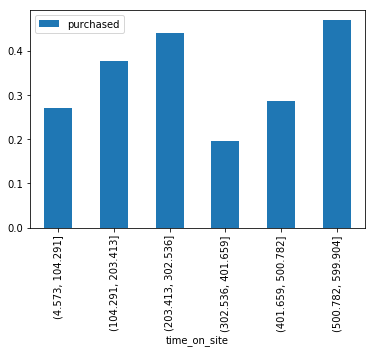

In [0]:
pt.plot.bar()

In [0]:
ct = pd.crosstab(time_bins, [user_data['purchased'], user_data['mobile']],
                 normalize='columns')
ct

# question: how do you graph just the last two columns from this crosstab?

purchased              False               True           
mobile                 False     True      False     True 
time_on_site                                              
(4.573, 104.291]    0.181319  0.376623  0.073529  0.250000
(104.291, 203.413]  0.142857  0.333333  0.161765  0.340278
(203.413, 302.536]  0.192308  0.290043  0.220588  0.409722
(302.536, 401.659]  0.225275  0.000000  0.147059  0.000000
(401.659, 500.782]  0.164835  0.000000  0.176471  0.000000
(500.782, 599.904]  0.093407  0.000000  0.220588  0.000000

In [0]:
ct_final = ct.iloc[:, [2,3]]
ct_final

purchased               True          
mobile                 False     True 
time_on_site                          
(4.573, 104.291]    0.073529  0.250000
(104.291, 203.413]  0.161765  0.340278
(203.413, 302.536]  0.220588  0.409722
(302.536, 401.659]  0.147059  0.000000
(401.659, 500.782]  0.176471  0.000000
(500.782, 599.904]  0.220588  0.000000

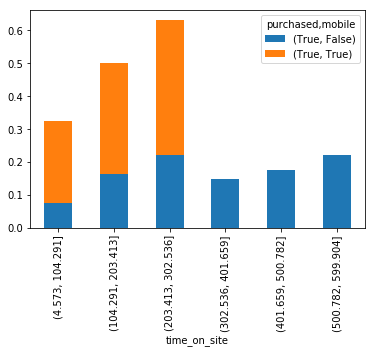

In [0]:
ct_final.plot(kind='bar', stacked=True)

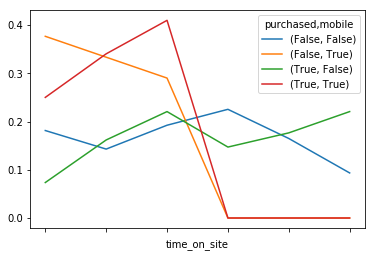

In [0]:
ct.plot()

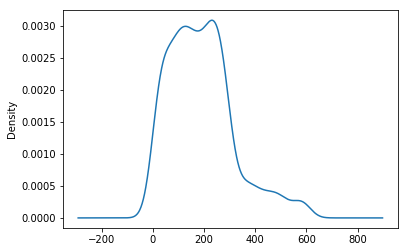

In [0]:
user_data['time_on_site'].plot.density();
# density plot is basically a smoothed histogram

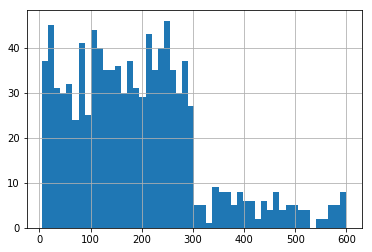

In [0]:
user_data['time_on_site'].hist(bins=50)

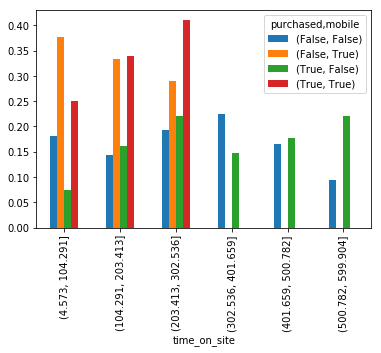

In [0]:
ct.plot(kind='bar')

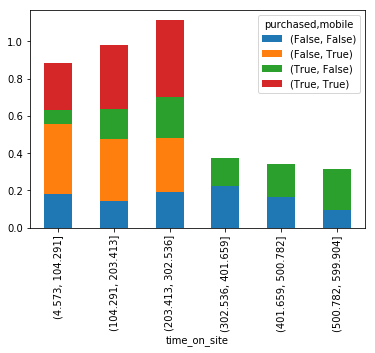

In [0]:
ct.plot(kind='bar', stacked=True)

## Assignment - what's going on here?

Consider the data in `persons.csv` (already prepared for you, in the repo for the week). It has four columns - a unique id, followed by age (in years), weight (in lbs), and exercise time (in minutes/week) of 1200 (hypothetical) people.

Try to figure out which variables are possibly related to each other, and which may be confounding relationships.

In [0]:
!pip install pandas==0.23.4
import pandas as pd
person_data = pd.read_csv('https://raw.githubusercontent.com/LambdaSchool/DS-Unit-1-Sprint-1-Dealing-With-Data/master/module3-databackedassertions/persons.csv')
person_data.head()

,Unnamed: 0,age,weight,exercise_time
0,0,44,118,192
1,1,41,161,35
2,2,46,128,220
3,3,39,216,57
4,4,28,116,182


In [0]:
print(person_data.shape)
print()
print(person_data.dtypes)
print()
print(person_data.isnull().sum())
print()
person_data.describe()

(1200, 4)

Unnamed: 0       int64
age              int64
weight           int64
exercise_time    int64
dtype: object

Unnamed: 0       0
age              0
weight           0
exercise_time    0
dtype: int64



,Unnamed: 0,age,weight,exercise_time
count,1200.000000,1200.000000,1200.000000,1200.000000
mean,599.500000,48.396667,153.540833,134.910833
std,346.554469,18.166802,35.132182,85.548895
min,0.000000,18.000000,100.000000,0.000000
25%,299.750000,33.000000,125.000000,65.000000
50%,599.500000,48.000000,149.000000,122.000000
75%,899.250000,64.000000,180.250000,206.000000
max,1199.000000,80.000000,246.000000,300.000000


In [0]:
age_bins = pd.cut(person_data['age'], 6)
weight_bins = pd.cut(person_data['weight'], 6)
exercise_time_bins = pd.cut(person_data['exercise_time'], 6)

ct_age_weight = pd.crosstab(age_bins, weight_bins, normalize='columns')
ct_age_weight

weight,"(99.854, 124.333]","(124.333, 148.667]","(148.667, 173.0]","(173.0, 197.333]","(197.333, 221.667]","(221.667, 246.0]"
age,,,,,,
"(17.938, 28.333]",0.190476,0.187500,0.189723,0.136905,0.140845,0.128205
"(28.333, 38.667]",0.238095,0.161184,0.173913,0.166667,0.154930,0.102564
"(38.667, 49.0]",0.166667,0.210526,0.154150,0.130952,0.147887,0.128205
"(49.0, 59.333]",0.170068,0.164474,0.130435,0.166667,0.154930,0.025641
"(59.333, 69.667]",0.102041,0.157895,0.173913,0.190476,0.204225,0.230769
"(69.667, 80.0]",0.132653,0.118421,0.177866,0.208333,0.197183,0.384615


In [0]:
ct_age_exercise_time = pd.crosstab(age_bins, exercise_time_bins, normalize='columns')
ct_age_exercise_time

exercise_time,"(-0.3, 50.0]","(50.0, 100.0]","(100.0, 150.0]","(150.0, 200.0]","(200.0, 250.0]","(250.0, 300.0]"
age,,,,,,
"(17.938, 28.333]",0.120332,0.132576,0.170103,0.236842,0.251613,0.179487
"(28.333, 38.667]",0.199170,0.121212,0.149485,0.221053,0.219355,0.205128
"(38.667, 49.0]",0.112033,0.151515,0.128866,0.136842,0.232258,0.294872
"(49.0, 59.333]",0.107884,0.113636,0.149485,0.152632,0.154839,0.294872
"(59.333, 69.667]",0.182573,0.200758,0.170103,0.189474,0.141935,0.025641
"(69.667, 80.0]",0.278008,0.280303,0.231959,0.063158,0.000000,0.000000


In [0]:
ct_exercise_time_weight = pd.crosstab(exercise_time_bins, weight_bins, normalize='columns')
ct_exercise_time_weight

weight,"(99.854, 124.333]","(124.333, 148.667]","(148.667, 173.0]","(173.0, 197.333]","(197.333, 221.667]","(221.667, 246.0]"
exercise_time,,,,,,
"(-0.3, 50.0]",0.115646,0.121711,0.146245,0.279762,0.366197,0.871795
"(50.0, 100.0]",0.142857,0.154605,0.249012,0.267857,0.436620,0.128205
"(100.0, 150.0]",0.173469,0.088816,0.193676,0.244048,0.183099,0.000000
"(150.0, 200.0]",0.173469,0.203947,0.173913,0.184524,0.014085,0.000000
"(200.0, 250.0]",0.156463,0.207237,0.166008,0.023810,0.000000,0.000000
"(250.0, 300.0]",0.238095,0.223684,0.071146,0.000000,0.000000,0.000000


AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)


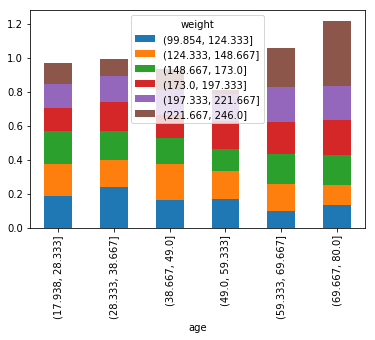

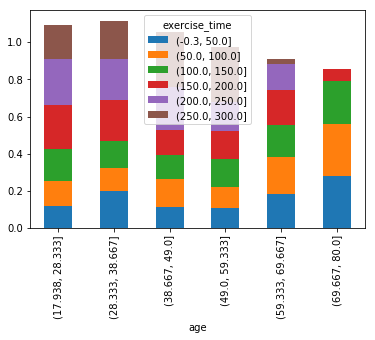

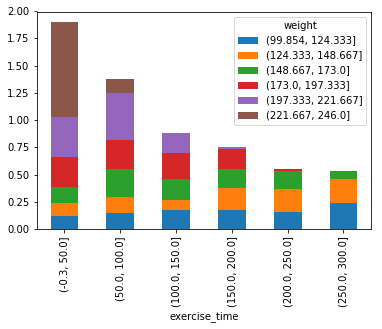

In [0]:
print(ct_age_weight.plot(kind='bar', stacked=True));
print(ct_age_exercise_time.plot(kind='bar', stacked=True));
print(ct_exercise_time_weight.plot(kind='bar', stacked=True));

In [0]:
age_bin_1 = person_data[person_data.age < 18 + (62/6)]
age_bin_2 = person_data[(person_data.age < 18 + 2*(62/6)) & (person_data.age > 18 + (62/6))]
age_bin_3 = person_data[(person_data.age < 18 + 3*(62/6)) & (person_data.age > 18 + 2*(62/6))]
age_bin_4 = person_data[(person_data.age < 18 + 4*(62/6)) & (person_data.age > 18 + 3*(62/6))]
age_bin_5 = person_data[(person_data.age < 18 + 5*(62/6)) & (person_data.age > 18 + 4*(62/6))]
age_bin_6 = person_data[person_data.age > 18 + 5*(62/6)]

exercise_time_bin_1 = person_data[person_data.exercise_time < 50]
exercise_time_bin_2 = person_data[(person_data.exercise_time < 100) & (person_data.exercise_time > 50)]
exercise_time_bin_3 = person_data[(person_data.exercise_time < 150) & (person_data.exercise_time > 100)]
exercise_time_bin_4 = person_data[(person_data.exercise_time < 200) & (person_data.exercise_time > 150)]
exercise_time_bin_5 = person_data[(person_data.exercise_time < 250) & (person_data.exercise_time > 200)]
exercise_time_bin_6 = person_data[person_data.exercise_time > 250]

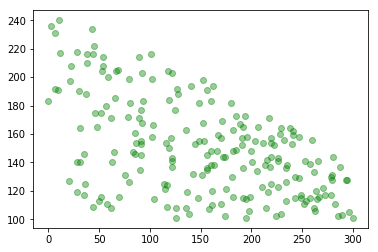

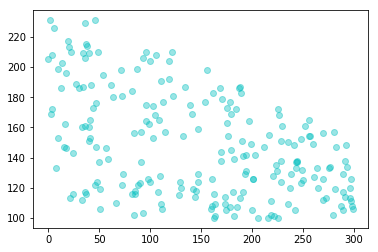

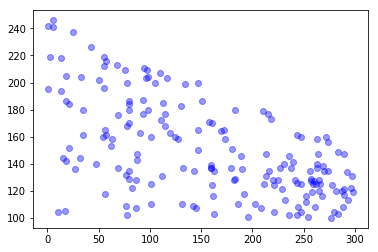

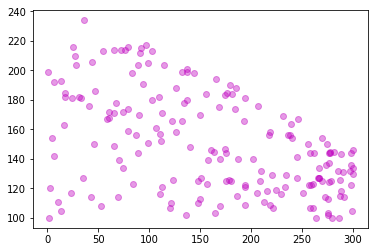

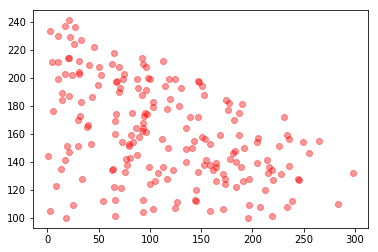

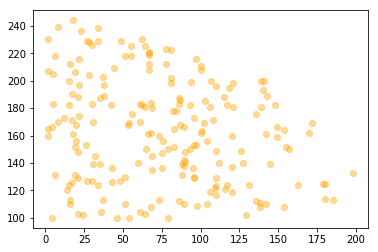

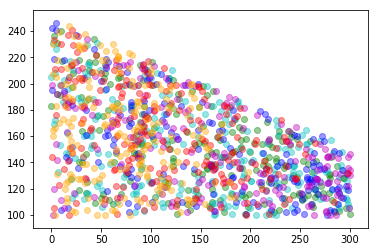

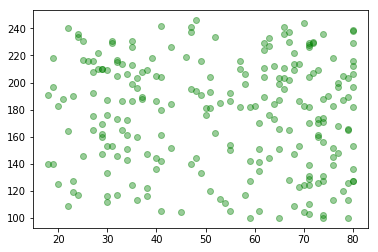

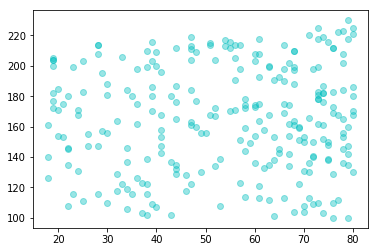

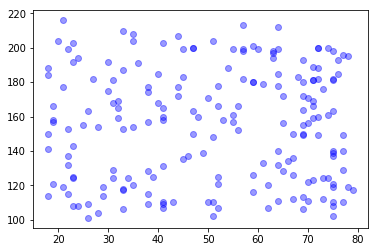

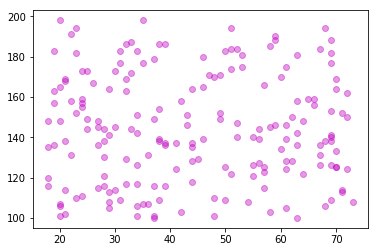

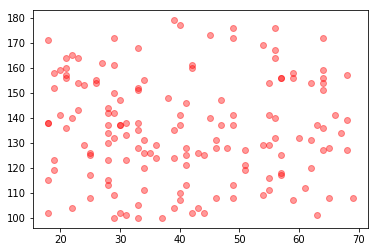

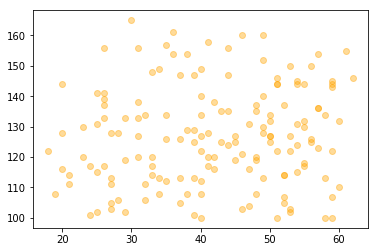

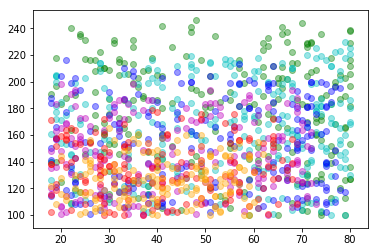

In [0]:
import matplotlib.pyplot as plt

plt.scatter(age_bin_1.exercise_time, age_bin_1.weight, color ='g', alpha = .4)
plt.show()
plt.scatter(age_bin_2.exercise_time, age_bin_2.weight, color ='c', alpha = .4)
plt.show()
plt.scatter(age_bin_3.exercise_time, age_bin_3.weight, color ='b', alpha = .4)
plt.show()
plt.scatter(age_bin_4.exercise_time, age_bin_4.weight, color ='m', alpha = .4)
plt.show()
plt.scatter(age_bin_5.exercise_time, age_bin_5.weight, color ='r', alpha = .4)
plt.show()
plt.scatter(age_bin_6.exercise_time, age_bin_6.weight, color ='orange', alpha = .4)
plt.show()

plt.scatter(age_bin_1.exercise_time, age_bin_1.weight, color ='g', alpha = .4)
plt.scatter(age_bin_2.exercise_time, age_bin_2.weight, color ='c', alpha = .4)
plt.scatter(age_bin_3.exercise_time, age_bin_3.weight, color ='b', alpha = .4)
plt.scatter(age_bin_4.exercise_time, age_bin_4.weight, color ='m', alpha = .4)
plt.scatter(age_bin_5.exercise_time, age_bin_5.weight, color ='r', alpha = .4)
plt.scatter(age_bin_6.exercise_time, age_bin_6.weight, color ='orange', alpha = .4)
plt.show()

plt.scatter(exercise_time_bin_1.age, exercise_time_bin_1.weight, color ='g', alpha = .4)
plt.show()
plt.scatter(exercise_time_bin_2.age, exercise_time_bin_2.weight, color ='c', alpha = .4)
plt.show()
plt.scatter(exercise_time_bin_3.age, exercise_time_bin_3.weight, color ='b', alpha = .4)
plt.show()
plt.scatter(exercise_time_bin_4.age, exercise_time_bin_4.weight, color ='m', alpha = .4)
plt.show()
plt.scatter(exercise_time_bin_5.age, exercise_time_bin_5.weight, color ='r', alpha = .4)
plt.show()
plt.scatter(exercise_time_bin_6.age, exercise_time_bin_6.weight, color ='orange', alpha = .4)
plt.show()

plt.scatter(exercise_time_bin_1.age, exercise_time_bin_1.weight, color ='g', alpha = .4)
plt.scatter(exercise_time_bin_2.age, exercise_time_bin_2.weight, color ='c', alpha = .4)
plt.scatter(exercise_time_bin_3.age, exercise_time_bin_3.weight, color ='b', alpha = .4)
plt.scatter(exercise_time_bin_4.age, exercise_time_bin_4.weight, color ='m', alpha = .4)
plt.scatter(exercise_time_bin_5.age, exercise_time_bin_5.weight, color ='r', alpha = .4)
plt.scatter(exercise_time_bin_6.age, exercise_time_bin_6.weight, color ='orange', alpha = .4)
plt.show()

### Assignment questions

After you've worked on some code, answer the following questions in this text block:

1.  What are the variable types in the data?

The three variables - age, weight, and exercise time - are all continuous and ordinal, though age is discretized into years, weight is discretized into pounds, and exercise time is discretized into minutes.  (We could, in principle, represent age, weight, and exercise time to any precision we want; we need not round to the nearest year, pound, or minute.)  By binning each of these variables, we further discretize; each variable falls into a bin ordered from one through six.

2.  What are the relationships between the variables?

As people age, their weight increases.

As people age, their exercise time decreases.

As people exercise less, their weight increases.

Age may be a confounding variable.  Exercise time is an independent variable and weight is a dependent variable; age seems to influence both, decreasing the former and increasing the latter.

3.  Which relationships are "real", and which spurious?

Looking at the scatterplots that control for age, it seems clear that lack of exercise does cause weight gain - when we compare people in the same age bin, we consistently see that people who exercise more weigh less.  Looking at the scatterplots that control for exercise time, however, it is far less clear that age causes weight gain - while there might be an extremely modest trend, people in the same exercise time bin show similar weights regardless of age.

## Stretch goals and resources

Following are *optional* things for you to take a look at. Focus on the above assignment first, and make sure to commit and push your changes to GitHub.

- [Spurious Correlations](http://tylervigen.com/spurious-correlations)
- [NIH on controlling for confounding variables](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4017459/)

Stretch goals:

- Produce your own plot inspired by the Spurious Correlation visualizations (and consider writing a blog post about it - both the content and how you made it)
- Pick one of the techniques that NIH highlights for confounding variables - we'll be going into many of them later, but see if you can find which Python modules may help (hint - check scikit-learn)